<h1> <center>Riiid! Answer Correctness Prediction </h1>
   

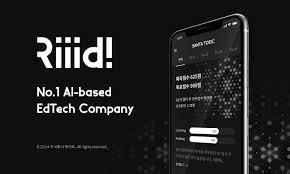

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h2> Table of content</h2>
<ul><li><a id="#preparation"> Preperation </a> </li>
    <li> <a id="#data"> Load the datas </a> </li> 
    <li> <a id="#data_preparation"> Data Preparation </a> </li>
    <li> <a id="#feature_engineering"> Feature engineering </a> </li>
    <li> <a id="#exploration"> Datas Explorations </a> </li>
    <li> <a id="#preprocessing"> Data preprocessing </a> </li>
</ul>
</br>

<h2 id=preparation> Preperation</h2>
<p> Import the required librairies </p>

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import gc

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

<h2 id="data"> Load the datas </h2>

In [ ]:
train=pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',dtype={'row_id':'int64',\
                                                                               'timestamp':'int64',\
                                                                               'user_id':'int32',\
                                                                               'content_id':'int16',\
                                                                               'content_type_id':'int8',\
                                                                               'task_container_id':'int16',\
                                                                               'user_answer':'int8',\
                                                                               'answered_correctly':'int8',\
                                                                               'prior_question_elapsed_time':'float32',\
                                                                               'prior_question_had_explanation':'boolean'})

In [ ]:
train=train.sort_values(by=['timestamp'])

<h2 id=data_preparation> Data Preparation </h2>

<p> <font color=greenwhite> <b> We will imput missing values for the variables prior_question_elapsed_time and prior_question_had_explanation.

In [ ]:
#We know for users first question bundle, prior_question_elapsed_time should be null and prior_question_had_explanation should be False.
train['prior_question_elapsed_time'].fillna(0,inplace=True)


In [ ]:
train['prior_question_had_explanation'].fillna(False,inplace=True)

In [ ]:
train=train.sort_values(by=["timestamp"])

<h2 id="feature_engineering"> Feature engineering </h2>

In [ ]:
def nb_previous_lectures(i):
    idd=train.loc[i,'user_id']
    indices=[j  for j in train.index if j<=i]
    ext=train.loc[indices]
    dd=ext[(ext['user_id']==idd) & (ext['content_type_id']==1)]
    nb=dd['content_type_id'].sum()
    return nb

<h2 id=exploration> Datas Explorations </h2>

In [ ]:
# Number of students on this dataset.

users=len(train['user_id'].unique())
print('There is data of {} students in the training set '.format(users))

In [ ]:
# percentil of the question and lecture events in the training dataset.
events={0:"question",1:"lecture"}
labels=list(events.values())
val=[train['content_type_id'].value_counts().loc[0],train['content_type_id'].value_counts().loc[1]]

In [ ]:
fig=px.pie(names=labels,values=val,title="events percentile")
fig.update_layout(title={'x':0.475,'y':0.9,'xanchor':'center','yanchor':'top'})
fig.show()

<p> <font color=greenwhite><b> More than 98 % of the events in our training datas are question events. </b></p>

In [ ]:
# substructe the data concern only the question events.
qt=train[train['content_type_id']==1]
tr=train[train['content_type_id']==0]


In [ ]:
tr_u=tr.groupby(['user_id']).agg({'answered_correctly':'mean'})
tr_u=reduce_mem_usage(tr_u)

In [ ]:
fig=px.histogram(tr_u,x='answered_correctly',title='distribution of performance  level of students ',\
                 nbins=10,histnorm='probability')
fig.update_layout(title={'x':0.475,'y':0.9,'xanchor':'center','yanchor':'top'})
fig.show()

<font color=greenwhite><b> We notice from the chart above that :        
    - About 50% of students reply correctly to 50% until 70% of their questions.   
    - About 17% of students reply correctly to 70% until 90% of their questions.   
    - About 0.3 of students reply correctly to 100% of their questions.    
==> About 67% of the students reply correctly to more than 50% of their questions.</b>

In [ ]:
del(users)
del(events)
del(labels)
del(val)

In [ ]:
df=pd.pivot_table(tr,index=["prior_question_had_explanation"],\
                  values=["answered_correctly"],aggfunc='sum')
df['answered_correctly']=(df['answered_correctly']/len(tr))*100

In [ ]:
sns.heatmap(df,annot=True,cbar=False)
plt.title("Pivot table of answered_correctly with prior_question_had_explanation")

<font color=greenwhite><b> 61% of correct answers had carried out by students who had seen prior questions explanation. Moreover, students who had not seen previous questions explanation, sucssed only in 4.9 % of questions.
    
    ==> reading previous questions explanations is very helpful task to enhance student performance level. 

In [ ]:
def quartile_range(vl,q1,q2,q3):
    """ This function allow to class the value of the introduced variable into his quartile range."""
    if vl<=q1:
        return "Q1"
    elif q1<vl<=q2:
        return "Q2"
    elif q2<vl<=q3:
        return "Q3"
    else:
        return "Q4"

In [ ]:
df=tr[["answered_correctly","prior_question_elapsed_time"]]
q1=df["prior_question_elapsed_time"].quantile(0.25)
q2=df["prior_question_elapsed_time"].quantile(0.5)
q3=df["prior_question_elapsed_time"].quantile(0.75)
df['prior_question_elapsed_time_quartile']=[quartile_range(vl,q1,q2,q3) \
                                            for vl in df['prior_question_elapsed_time']]

In [ ]:
cnt=df[["answered_correctly","prior_question_elapsed_time_quartile"]].pivot_table(index="answered_correctly",\
                                                                             columns="prior_question_elapsed_time_quartile",aggfunc=len)
tx=df['answered_correctly'].value_counts()
ty=df["prior_question_elapsed_time_quartile"].value_counts()
tx=pd.DataFrame(tx)
ty=pd.DataFrame(ty)
tx.columns=['values']
ty.columns=['values']
n=len(df)
ind=tx.dot(ty.T)/n
ms=((cnt-ind)**2)/ind
cf=ms.sum().sum()
sns.heatmap(cnt,annot=True)
plt.title("Pivot table of answered_correctly with prior_question_elapsed_time quartile")

In [ ]:
print("The estimated correlation between answered_correctly and prior_question_elapsed_time_quartile equal \
to :{}".format(cf))

<font color=greenwhite><b> We notice from the chart above, that the elapsed time for the previous question, affect the ability of student to reply correctly to the question. More the elapsed time fom the prior question is high, less the student has a chance to reply correctly to the question.

In [ ]:
del(df)
del(cnt)
del(q1)
del(q2)
del(q3)

In [ ]:
lectures=qt.groupby('user_id').agg({"content_type_id":['count']})

In [ ]:
lectures=lectures.reset_index()

In [ ]:
lectures.columns=['user_id','lectures_count']

In [ ]:
user_time=train.groupby('user_id').agg({'timestamp':['max']})

In [ ]:
user_time=user_time.reset_index()
user_time.columns=['user_id','max_timestamp']

In [ ]:
lectures=lectures.merge(user_time,on='user_id',how='left')

In [ ]:
lectures["time_lecture"]=lectures["max_timestamp"]/lectures["lectures_count"]

In [ ]:
del(lectures["max_timestamp"])
del(lectures["lectures_count"])

In [ ]:
del(train)
del(user_time)
del(qt)

In [ ]:
tr=tr.merge(lectures,on='user_id',how='left')

In [ ]:
df=tr[['answered_correctly','time_lecture']]

In [ ]:
q1=df['time_lecture'].quantile(0.25)
q2=df['time_lecture'].quantile(0.5)
q3=df['time_lecture'].quantile(0.75)
df['time_lecture_quantile']=[quartile_range(v,q1,q2,q3) for v in df["time_lecture"]]

In [ ]:
cnt=df[['answered_correctly','time_lecture_quantile']].pivot_table(index="answered_correctly",\
                                                                  columns="time_lecture_quantile",aggfunc=len)

tx=df['answered_correctly'].value_counts()
ty=df['time_lecture_quantile'].value_counts()
tx=pd.DataFrame(tx)
ty=pd.DataFrame(ty)
tx.columns=['values']
ty.columns=['values']
n=len(df)
ind=tx.dot(ty.T)/n
mesure=((cnt-ind)**2)/ind
coef=mesure.sum().sum()
sns.heatmap(cnt,annot=True)
plt.title("correlation betwen correct answer and number of lecture by time of each student")

In [ ]:
print("The estimated correlation coeficient between answered_correctly and number\
of previous lecture of each student equal to :{}".format(coef))

<font color=greenwhite><b> The green graph above and the estimated correlation mesure between answered_correctly and time_lecture_quantile , confirm the high correlation between them. It means the ability of the student to reply correctly on each question depend to his lecture frequency.